# Moving Averages CINGULATE region

### 1) Imports

In [4]:
import os
import glob
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)

In [214]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

from preprocess import SkeletonDataset
import torch
from vae import *

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

In [6]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [8]:
path = '/neurospin/dico/data/deep_folding/papers/midl2022/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [9]:
if torch.cuda.is_available():
    device = "cuda:0"

In [10]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/gridsearch/n_4_kl_2/'
model = VAE((1, 20, 40, 40), 4, depth=3)
model.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model = model.to(device)

In [11]:
subject_dir = "/neurospin/dico/data/deep_folding/papers/midl2022/"
data_dir = "/neurospin/dico/data/deep_folding/papers/midl2022/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/"

train_list = pd.read_csv(os.path.join(subject_dir,
                         f"HCP_half_{1}bis.csv"), header=None,
                         usecols=[0], names=['subjects'])

train_list['subjects'] = train_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(train_list, left_on = tmp.index, right_on='subjects', how='right')

filenames = list(train_list['subjects'])

subset = SkeletonDataset(dataframe=tmp, filenames=filenames)

In [12]:
dataloader = torch.utils.data.DataLoader(
              subset,
              batch_size=64,
              num_workers=8,
              shuffle=True)    

In [14]:
dico_set_loaders = {'data': dataloader}

root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/n_4_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3)

In [15]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['data']
X = np.array(list(df_encoded['latent']))
labels = list(results['data'].keys())

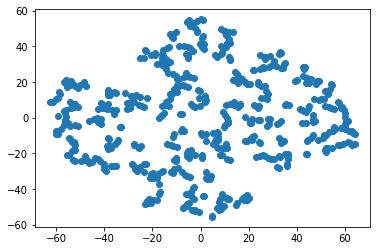

In [16]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=8, random_state=12).fit_transform(X)

x = [X_embedded[k][0] for k in range(len(X_embedded))]
y = [X_embedded[k][1] for k in range(len(X_embedded))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

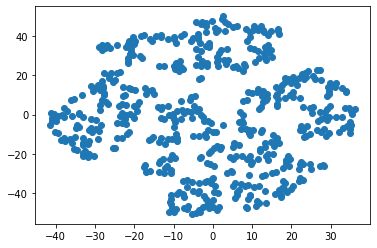

In [17]:
X_embedded1 = TSNE(n_components=2, perplexity=15).fit_transform(X)

x = [X_embedded1[k][0] for k in range(len(X_embedded))]
y = [X_embedded1[k][1] for k in range(len(X_embedded))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [18]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [24]:
af = AffinityPropagation(random_state=15, max_iter=1000).fit(X_embedded1)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X_embedded1)
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(X_embedded1[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X_embedded1)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

18
4
cluster's centroids coordinates: 
 [[ -3.8339486  40.834236 ]
 [  6.5797772 -38.245735 ]
 [ 13.75447     8.431591 ]
 [-22.325718   -2.3538938]]


In [25]:
metrics.silhouette_score(X_embedded1, x_cluster_label)

0.4469887

In [20]:
af = AffinityPropagation(random_state=0, max_iter=1000).fit(X)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X)
while n_clusters_ > 5:
    af = AffinityPropagation(random_state=0).fit(X[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

33
6
3
cluster's centroids coordinates: 
 [[ 0.88564706  0.31012303  1.7039871   1.552712  ]
 [-0.42543092 -2.1573017   1.5635158   0.5839155 ]
 [ 1.3927503  -1.1905932  -0.16101934  0.91791344]]


In [21]:
metrics.silhouette_score(X, x_cluster_label)

0.15972105

In [26]:
dstrb_sub = pd.DataFrame(X_embedded1, index=labels, columns=[1, 2])
dstrb_sub['cluster_lab'] = x_cluster_label

In [27]:
cluster1 = dstrb_sub[dstrb_sub.cluster_lab==0]
cluster2 = dstrb_sub[dstrb_sub.cluster_lab==1]
cluster3 = dstrb_sub[dstrb_sub.cluster_lab==2]
cluster4 = dstrb_sub[dstrb_sub.cluster_lab==3]
assert(len(np.unique(list(cluster1.cluster_lab)))==1)
assert(len(np.unique(list(cluster2.cluster_lab)))==1)
assert(len(np.unique(list(cluster3.cluster_lab)))==1)
assert(len(np.unique(list(cluster4.cluster_lab)))==1)

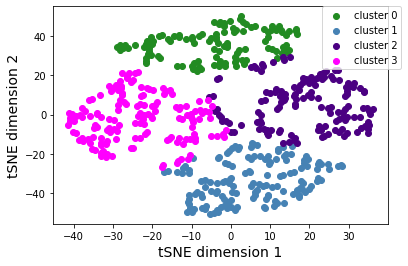

In [28]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[:2]]) for i in range(len(dstrb_sub))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [29]:
central_1 = closest_distance(clusters_centroids[0], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")
central_3 = closest_distance(clusters_centroids[2], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 3 is {central_3}")
central_4 = closest_distance(clusters_centroids[3], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 4 is {central_4}")

Closest subject to centroid of cluster 1 is 180432
Closest subject to centroid of cluster 2 is 199958
Closest subject to centroid of cluster 3 is 191336
Closest subject to centroid of cluster 4 is 387959


### Creation of buckets dictionnary

In [31]:
bucket_path = '/neurospin/dico/data/deep_folding/papers/midl2022/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

100%|██████████| 550/550 [00:48<00:00, 11.26it/s]


In [32]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index
subjects_c3 = cluster3.index
subjects_c4 = cluster4.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}
buckets_c3 = {k: v for k,v in buckets.items() if k in list(subjects_c3)}
buckets_c4 = {k: v for k,v in buckets.items() if k in list(subjects_c4)}

#### Alignement of the subjects to respective central subject

In [33]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2)
aligned_buckets_C3, aligned_rot_C3, aligned_transl_C3 = ma.align_buckets_by_ICP_batch(buckets_c3, central_3)
aligned_buckets_C4, aligned_rot_C4, aligned_transl_C4 = ma.align_buckets_by_ICP_batch(buckets_c4, central_4)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 180432: 100%|██████████| 115/115 [00:01<00:00, 96.81it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 199958: 100%|██████████| 144/144 [00:01<00:00, 89.40it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 191336: 100%|██████████| 138/138 [00:01<00:00, 101.16it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 387959: 100%|██████████| 153/153 [00:01<00:00, 105.95it/s]


In [34]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=5):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=5):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord, num_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

### TSNE AXIS 1 analysis

In [35]:
MA_coords_1 = [dstrb_sub.loc[central_1][1]]
MA_coords_2 = [dstrb_sub.loc[central_2][1]]
MA_coords_3 = [dstrb_sub.loc[central_3][1]]
MA_coords_4 = [dstrb_sub.loc[central_4][1]]

#### Parameters

In [57]:
axis = 1

#### Cluster 1

In [58]:
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords_1, aligned_buckets_C1, cluster1, axis_n=axis, FWHM=100)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


In [59]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, threshold="88%", gblur_sigma=0.3, smoothRate=0.1, deciReductionRate=0)
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, 0, axis=0, scale=1)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_cluster_1_rebuttal.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 24.35it/s]


#### Cluster 2

In [60]:
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(MA_coords_2, aligned_buckets_C2, cluster2, axis_n=axis, FWHM=10)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


In [61]:
SPAM_meshes_2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes_2[k]=dtx.convert.volume_to_mesh(
                    vol=volume,threshold="88%", gblur_sigma=0.20, smoothRate=0.1, deciReductionRate=0)
    
shifted_SPAM_meshes_2 = {}
for dist, mesh in SPAM_meshes_2.items():
    shifted_SPAM_meshes_2[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, 0, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_2.items()):
    aims.write(mesh, f"MA_cluster_2_rebuttal.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 29.35it/s]


#### Cluster 3

In [62]:
SPAM_vols_c3, shift3 = ma.calc_MA_volumes_batch(MA_coords_3, aligned_buckets_C3, cluster3, axis_n=axis, FWHM=10)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


In [63]:
SPAM_meshes_3 = {}

for k, volume in tqdm(list(SPAM_vols_c3.items())[:]):
    SPAM_meshes_3[k]=dtx.convert.volume_to_mesh(
                    vol=volume, threshold="88%", gblur_sigma=0.3, smoothRate=0.1, deciReductionRate=0)
    
shifted_SPAM_meshes_3 = {}
for dist, mesh in SPAM_meshes_3.items():
    shifted_SPAM_meshes_3[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, 0, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_3.items()):
    aims.write(mesh, f"MA_cluster_3_rebuttal.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 31.27it/s]


#### Cluster 4

In [64]:
SPAM_vols_c4, shift4 = ma.calc_MA_volumes_batch(MA_coords_4, aligned_buckets_C4, cluster4, axis_n=axis, FWHM=10)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


In [65]:
SPAM_meshes_4 = {}

for k, volume in tqdm(list(SPAM_vols_c4.items())[:]):
    SPAM_meshes_4[k]=dtx.convert.volume_to_mesh(
                    vol=volume, threshold="88%", gblur_sigma=0.3, smoothRate=0.1, deciReductionRate=0)
    
shifted_SPAM_meshes_4 = {}
for dist, mesh in SPAM_meshes_4.items():
    shifted_SPAM_meshes_4[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, 0, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_4.items()):
    aims.write(mesh, f"MA_cluster_4_rebuttal.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 31.87it/s]


### Visualisation of neighbours

In [36]:
def compute_distance(df_in, centroid):
    """Computes distance from centroid"""
    df_out = df_in
    df_out['distance'] = (df_out[1]-centroid[0])**2 + (df_out[2]-centroid[1])**2
    return df_out

In [37]:
distance = []
for i in cluster1.index:
    distance.append(np.linalg.norm(np.array(dstrb_sub.loc[i][:2])-clusters_centroids[0]))
cluster1['distance'] = distance
cluster1.sort_values(by='distance')[:4]

,1,2,cluster_lab,distance
180432,-3.833949,40.834236,0,0.000000
249947,-3.712269,39.632240,0,1.208139
169141,-4.935666,39.209450,0,1.963087
148335,-1.637442,41.806152,0,2.401929


In [38]:
distance = []
for i in cluster2.index:
    distance.append(np.linalg.norm(np.array(dstrb_sub.loc[i][:2])-clusters_centroids[1]))
cluster2['distance'] = distance
cluster2.sort_values(by='distance')[:4]

,1,2,cluster_lab,distance
199958,6.579777,-38.245735,1,0.000000
102513,6.021583,-39.582870,1,1.448969
160830,8.070105,-36.331730,1,2.425797
620434,5.097029,-36.310982,1,2.437584


In [39]:
distance = []
for i in cluster3.index:
    distance.append(np.linalg.norm(np.array(dstrb_sub.loc[i][:2])-clusters_centroids[2]))
cluster3['distance'] = distance
cluster3.sort_values(by='distance')[:4]

,1,2,cluster_lab,distance
191336,13.754470,8.431591,2,0.000000
173536,13.511868,7.500074,2,0.962590
208428,12.425881,9.562613,2,1.744809
188751,13.825003,10.412747,2,1.982412


In [40]:
distance = []
for i in cluster4.index:
    distance.append(np.linalg.norm(np.array(dstrb_sub.loc[i][:2])-clusters_centroids[3]))
cluster4['distance'] = distance
cluster4.sort_values(by='distance')[:4]

,1,2,cluster_lab,distance
387959,-22.325718,-2.353894,3,0.000000
169949,-23.242138,-4.131948,3,2.000325
616645,-22.177753,-0.162821,3,2.196063
198653,-20.139189,-1.893451,3,2.234484


## Replication with model trained on HCP half 2

In [41]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/half2/n_4_kl_2/'
model_2 = VAE((1, 20, 40, 40), 4, depth=3)
model_2.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model_2 = model_2.to(device)

In [43]:
root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/model_2_n_4_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model_2, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3)

In [44]:
results_2 = tester.test()
encoded_2 = {loader_name:[results_2[loader_name][k] for k in results_2[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded_2 = pd.DataFrame()
df_encoded_2['latent'] = encoded_2['data']
X_2 = np.array(list(df_encoded_2['latent']))
labels_2 = list(results_2['data'].keys())

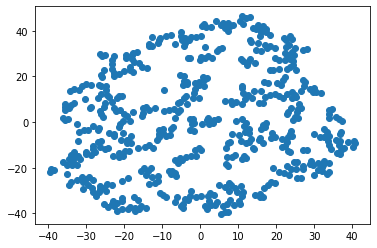

In [45]:
from sklearn.manifold import TSNE
X_embedded_2 = TSNE(n_components=2, perplexity=15).fit_transform(X_2)

x = [X_embedded_2[k][0] for k in range(len(X_embedded_2))]
y = [X_embedded_2[k][1] for k in range(len(X_embedded_2))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [46]:
af = AffinityPropagation(random_state=20, max_iter=1000).fit(X_embedded_2)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X_embedded_2)
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(X_embedded_2[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X_embedded_2)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_

19
4


In [47]:
dstrb_sub_2 = pd.DataFrame(X_embedded_2, index=labels_2, columns=[1, 2])
dstrb_sub_2['cluster_lab_half2'] = x_cluster_label
dstrb_sub_2['subjects'] = dstrb_sub_2.index

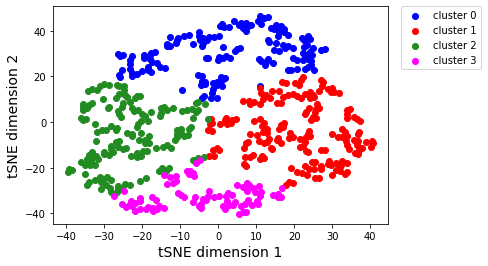

In [48]:
arr = np.array([np.array([dstrb_sub_2[k][i] for k in dstrb_sub_2.columns[:2]]) for i in range(len(dstrb_sub_2))])

color_dict = {0:'blue',1: 'red', 2:'forestgreen', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub_2.cluster_lab_half2]):
    ix = np.where(dstrb_sub_2.cluster_lab_half2 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [49]:
m1 = pd.merge(dstrb_sub, dstrb_sub_2, left_on=dstrb_sub.index, right_on=dstrb_sub_2.subjects)

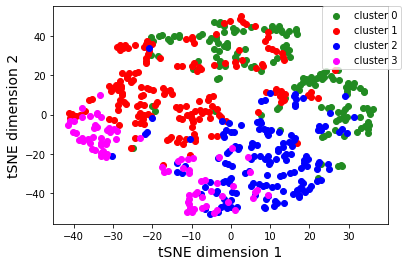

In [50]:
arr = np.array([np.array([m1[k][i] for k in m1.columns[1:3]]) for i in range(len(m1))])

color_dict = {0:'forestgreen',1: 'red', 2:'blue', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m1.cluster_lab_half2]):
    ix = np.where(m1.cluster_lab_half2 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [51]:
m1.head()

,key_0,1_x,2_x,cluster_lab,1_y,2_y,cluster_lab_half2,subjects
0,131924,-19.186666,5.052786,3,33.971924,3.695388,1,131924
1,692964,17.274990,12.390187,2,1.337422,27.923479,0,692964
2,159946,-23.090307,0.775272,3,23.239372,4.410473,1,159946
3,122822,13.033621,31.161682,0,35.807732,2.355009,1,122822
4,352132,8.874580,-42.764572,1,-32.392471,-25.393684,2,352132


In [52]:
metrics.accuracy_score(m1.cluster_lab, m1.cluster_lab_half2)

0.2690909090909091

In [53]:
metrics.adjusted_rand_score(m1.cluster_lab, m1.cluster_lab_half2)

0.2910046867813216

In [54]:
metrics.balanced_accuracy_score(m1.cluster_lab_half2, m1.cluster_lab)

0.3116733754226572

In [55]:
metrics.rand_score(m1.cluster_lab_half2,m1.cluster_lab,)

0.7287497930120881

In [495]:
metrics.cluster.adjusted_mutual_info_score(m1.cluster_lab_half2,m1.cluster_lab)

0.37205333333690926

### Score cluster most stable vs the others

In [478]:
e1 = m1.copy()
e2 = m1.copy()

In [479]:
e1 = e1.cluster_lab
e2 = e2.cluster_lab_half2

In [492]:
result = np.empty([4,4])
for i in range(4):
    for j in range(4):
        e1_i = e1.mask(e1!=i, 5)
        e2_j = e2.mask(e2!=j, 5)
        result[i,j] = round(metrics.cluster.adjusted_mutual_info_score(e1_i, e2_j),2)

In [493]:
result

array([[ 0.1 ,  0.01,  0.12,  0.08],
       [ 0.11,  0.2 ,  0.27,  0.03],
       [ 0.1 ,  0.02, -0.  ,  0.09],
       [ 0.14,  0.15,  0.09,  0.05]])

In [472]:
m1

,key_0,1_x,2_x,cluster_lab,1_y,2_y,cluster_lab_half2,subjects
0,131924,-19.186666,5.052786,3,33.971924,3.695388,1,131924
1,692964,17.274990,12.390187,2,1.337422,27.923479,0,692964
2,159946,-23.090307,0.775272,3,23.239372,4.410473,1,159946
3,122822,13.033621,31.161682,0,35.807732,2.355009,1,122822
4,352132,8.874580,-42.764572,1,-32.392471,-25.393684,2,352132
5,828862,29.595167,10.288410,2,-13.533621,34.261936,0,828862
6,127933,-20.832254,33.991020,0,-21.180027,5.235094,2,127933
7,300618,-10.844589,-44.306549,1,-16.348511,-33.893333,3,300618
8,199251,24.591726,3.274283,2,-5.335350,20.476217,0,199251
9,120414,12.215754,3.989527,2,-0.360186,10.477054,0,120414


In [466]:
m1.mask(m1.cluster_lab!=0, 5)

,key_0,1_x,2_x,cluster_lab,1_y,2_y,cluster_lab_half2,subjects
0,5,5.000000,5.000000,5,5.000000,5.000000,5,5
1,5,5.000000,5.000000,5,5.000000,5.000000,5,5
2,5,5.000000,5.000000,5,5.000000,5.000000,5,5
3,122822,13.033621,31.161682,0,35.807732,2.355009,1,122822
4,5,5.000000,5.000000,5,5.000000,5.000000,5,5
5,5,5.000000,5.000000,5,5.000000,5.000000,5,5
6,127933,-20.832254,33.991020,0,-21.180027,5.235094,2,127933
7,5,5.000000,5.000000,5,5.000000,5.000000,5,5
8,5,5.000000,5.000000,5,5.000000,5.000000,5,5
9,5,5.000000,5.000000,5,5.000000,5.000000,5,5


In [ ]:
for i in range(4):
    for j in range(4):
        e1_i = e1.mask(e1!=i, 5)
        e2_j = e2.mask(e2!=j, 5)
        result[i,j] = round(adjusted_mutual_info_score(e1_i, e2_j, average_method='arithmetic'),2)

In [451]:
sub_score_stable = pd.DataFrame()
sub_score_stable['subjects'] = list(m1.subjects)
sub_score_stable['labels_1'] = list(m1.cluster_lab)
sub_score_stable['labels_2'] = list(m1.cluster_lab_half2)

In [453]:
sub_score_stable['labels_1'] = np.where(sub_score_stable['labels_1'] != 1, 0,1)
sub_score_stable['labels_2'] = np.where(sub_score_stable['labels_2'] != 1, 0,1)

In [455]:
sub_score_stable

,subjects,labels_1,labels_2
0,131924,0,1
1,692964,0,0
2,159946,0,1
3,122822,0,1
4,352132,1,0
5,828862,0,0
6,127933,0,0
7,300618,1,0
8,199251,0,0
9,120414,0,0


In [459]:
print(metrics.accuracy_score(sub_score_stable.labels_1, sub_score_stable.labels_2))
print(metrics.adjusted_rand_score(sub_score_stable.labels_1, sub_score_stable.labels_2))
print(metrics.balanced_accuracy_score(sub_score_stable.labels_1, sub_score_stable.labels_2))
print(metrics.rand_score(sub_score_stable.labels_1, sub_score_stable.labels_2))
print(metrics.cluster.adjusted_mutual_info_score(sub_score_stable.labels_1, sub_score_stable.labels_2))

0.4254545454545455
-0.011185777787377602
0.2881773399014778
0.5102235469448584
0.19645945191567005


In [460]:
m1

,key_0,1_x,2_x,cluster_lab,1_y,2_y,cluster_lab_half2,subjects
0,131924,-19.186666,5.052786,3,33.971924,3.695388,1,131924
1,692964,17.274990,12.390187,2,1.337422,27.923479,0,692964
2,159946,-23.090307,0.775272,3,23.239372,4.410473,1,159946
3,122822,13.033621,31.161682,0,35.807732,2.355009,1,122822
4,352132,8.874580,-42.764572,1,-32.392471,-25.393684,2,352132
5,828862,29.595167,10.288410,2,-13.533621,34.261936,0,828862
6,127933,-20.832254,33.991020,0,-21.180027,5.235094,2,127933
7,300618,-10.844589,-44.306549,1,-16.348511,-33.893333,3,300618
8,199251,24.591726,3.274283,2,-5.335350,20.476217,0,199251
9,120414,12.215754,3.989527,2,-0.360186,10.477054,0,120414


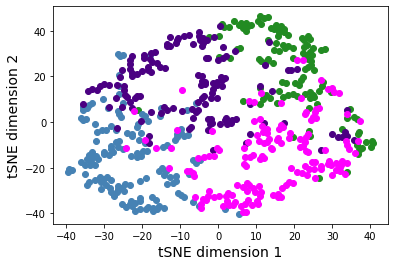

In [56]:
arr = np.array([np.array([m1[k][i] for k in m1.columns[4:6]]) for i in range(len(m1))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m1.cluster_lab]):
    ix = np.where(m1.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

### SimCLR

In [368]:
simclr = pd.read_csv('/home/lg261972/Téléchargements/simclr_labels.csv',)

In [379]:
simclr = simclr.rename(columns={'Unnamed: 0':'subjects'})
simclr.subjects = simclr.subjects.astype('str')

In [380]:
simclr.head()

,subjects,af_label
0,129634,3
1,136833,3
2,206222,1
3,138837,0
4,987983,0


In [384]:
simclr[simclr['subjects']=='352132']

,subjects,af_label
533,352132,2


In [372]:
dstrb_sub.head()

,1,2,cluster_lab
131924,-19.186666,5.052786,3
692964,17.274990,12.390187,2
159946,-23.090307,0.775272,3
122822,13.033621,31.161682,0
352132,8.874580,-42.764572,1


In [422]:
dstrb_sub.to_csv('/volatile/label_bvae.csv')

In [381]:
m2 = pd.merge(dstrb_sub, simclr, left_on=dstrb_sub.index, right_on=simclr.subjects)

In [382]:
m2.head()

,key_0,1,2,cluster_lab,subjects,af_label
0,131924,-19.186666,5.052786,3,131924,1
1,692964,17.274990,12.390187,2,692964,1
2,159946,-23.090307,0.775272,3,159946,1
3,122822,13.033621,31.161682,0,122822,1
4,352132,8.874580,-42.764572,1,352132,2


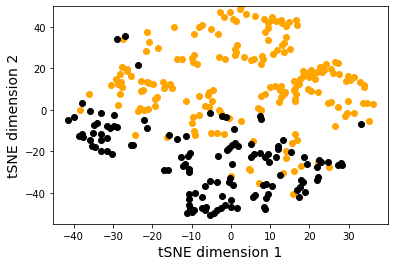

In [421]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'yellow',1: 'orange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([m2.af_label]):
    if g==2 or g==1:
        ix = np.where(m2.af_label == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        g_lab= f"cluster {g}"
        ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.ylim(-55,50)
plt.show()

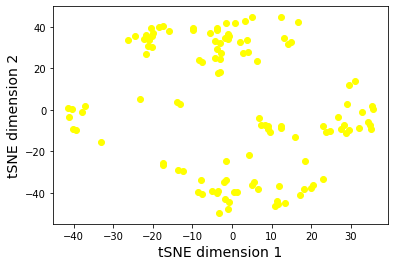

In [420]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'yellow',1: 'orange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([m2.af_label]):
    if g==0:
        ix = np.where(m2.af_label == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        g_lab= f"cluster {g}"
        ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.ylim(-55,50)
plt.show()

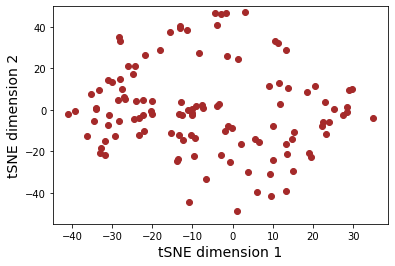

In [419]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'yellow',1: 'orange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([m2.af_label]):
    if g==3:
        ix = np.where(m2.af_label == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        g_lab= f"cluster {g}"
        ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.ylim(-55,50)
plt.show()

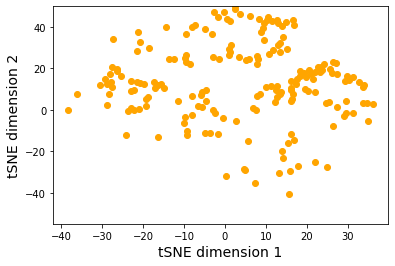

In [418]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'yellow',1: 'orange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([m2.af_label]):
    if g==1:
        ix = np.where(m2.af_label == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        g_lab= f"cluster {g}"
        ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.ylim(-55,50)
plt.show()

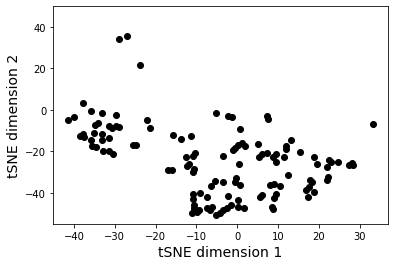

In [416]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'yellow',1: 'orange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([m2.af_label]):
    if g==2:
        ix = np.where(m2.af_label == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        g_lab= f"cluster {g}"
        ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.ylim(-55,50)
plt.show()

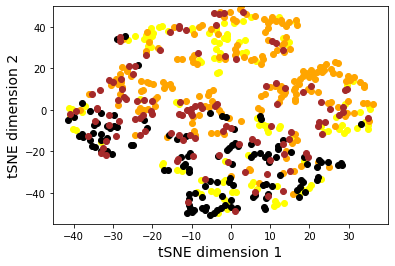

In [417]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'yellow',1: 'orange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([m2.af_label]):
    ix = np.where(m2.af_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.ylim(-55,50)
plt.show()

In [389]:
metrics.accuracy_score(m2.cluster_lab, m2.af_label)

0.21818181818181817

In [390]:
metrics.adjusted_rand_score(m2.cluster_lab, m2.af_label)

0.11271062595188075

In [391]:
metrics.balanced_accuracy_score(m2.af_label, m2.cluster_lab)

0.24159382026305448

In [392]:
metrics.rand_score(m2.af_label, m2.cluster_lab,)

0.6621162444113263

In [402]:
metrics.cluster.adjusted_mutual_info_score(m2.af_label, m2.cluster_lab)

0.13509974965722887

##### Better than chance ?

In [396]:
print("cluster 0", len(m2[m2.af_label==0]))
print("cluster 1", len(m2[m2.af_label==1]))
print("cluster 2", len(m2[m2.af_label==2]))
print("cluster 3", len(m2[m2.af_label==3]))

cluster 0 119
cluster 1 189
cluster 2 124
cluster 3 118


## Requested additional experiments - rebuttal

### Interpolation

#### Per cluster sampling sampling

In [88]:
df_encoded['subject'] = labels 
df_encoded['label'] = list(dstrb_sub.cluster_lab)

In [90]:
df_encoded.head()

,latent,subject,label
0,"[1.5352489, -1.538987, 1.2838997, 1.7825006]",131924,3
1,"[0.88564706, 0.31012303, 1.7039871, 1.552712]",692964,2
2,"[1.6594154, -2.1345892, 1.1293279, 0.97105825]",159946,3
3,"[1.3542801, -1.0678641, 1.4723233, 2.5523944]",122822,0
4,"[2.5835514, -0.24225658, 3.0845447, -1.1327147]",352132,1


In [105]:
list(df_encoded.label)[0]

3

In [164]:
z1 = [np.mean([df_encoded.latent[k][i] for k in range(len(df_encoded)) if list(df_encoded.label)[k]==0]) for i in range(4)]
print(z1)

[0.08940885, -1.7001817, 1.1901445, 2.1135442]


In [165]:
z2_mean = [np.mean([df_encoded.latent[k][i] for k in range(len(df_encoded)) if list(df_encoded.label)[k]==1]) for i in range(4)]
print(z2)

[1.4383482, -0.76982665, 2.348272, -0.8491852]


In [166]:
z3 = [np.mean([df_encoded.latent[k][i] for k in range(len(df_encoded)) if list(df_encoded.label)[k]==2]) for i in range(4)]
print(z3)

[0.8255699, -0.08156862, 1.8578597, 1.559993]


In [167]:
z4 = [np.mean([df_encoded.latent[k][i] for k in range(len(df_encoded)) if list(df_encoded.label)[k]==3]) for i in range(4)]
print(z4)

[1.6401873, -1.9146054, 0.58682525, 0.5391406]


In [168]:
arr_out = []
values = []
for enc, lab in zip([z1, z2, z3, z4], ['c0', 'c1', 'c2', 'c3', 'c4']):
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(lab)

arr_out = np.array(arr_out)
np.save(f"/volatile/arr_out.npy", arr_out)
np.save('/volatile/arr_label.npy', np.array(values))

##### Bucket conversion

In [169]:
import dico_toolbox as dtx

In [177]:
for k in range(4):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"/volatile/bucket_cluster{k}.bck")

##### Interpolation from cluster 0 to cluster 1

In [324]:
src_dir = "/neurospin/dico/lguillon/midl_22/visu_cluster_gen/"

In [318]:
dim1 = [z1[0]] + [z1[0] + ((z2[0]-z1[0])/5)*k for k in [1,2,3,4]] + [z2[0]]
dim2 = [z1[1]] + [z1[1] + ((z2[1]-z1[1])/5)*k for k in [1,2,3,4]] + [z2[1]]
dim3 = [z1[2]] + [z1[2] + ((z2[2]-z1[2])/5)*k for k in [1,2,3,4]] + [z2[2]]
dim4 = [z1[3]] + [z1[3] + ((z2[3]-z1[3])/5)*k for k in [1,2,3,4]] + [z2[3]]

In [325]:
arr_out = []
values = []

for k in range(6):
    enc = [dim1[k], dim2[k], dim3[k], dim4[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)
#np.save(f"/neurospin/dico/lguillon/midl_22/visu_cluster_gen/interpolation_0_1.npy", arr_out)
#np.save('/neurospin/dico/lguillon/midl_22/visu_cluster_gen/label_interpolation_0_1.npy', np.array(values))
for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_01/interpolation_bucket_step_{k}.bck")

##### Interpolation from cluster 0 to cluster 2

In [326]:
dim1 = [z1[0]] + [z1[0] + ((z3[0]-z1[0])/5)*k for k in [1,2,3,4]] + [z3[0]]
dim2 = [z1[1]] + [z1[1] + ((z3[1]-z1[1])/5)*k for k in [1,2,3,4]] + [z3[1]]
dim3 = [z1[2]] + [z1[2] + ((z3[2]-z1[2])/5)*k for k in [1,2,3,4]] + [z3[2]]
dim4 = [z1[3]] + [z1[3] + ((z3[3]-z1[3])/5)*k for k in [1,2,3,4]] + [z3[3]]

In [327]:
dim4

[2.1135442,
 2.0028339862823485,
 1.8921237468719483,
 1.7814135074615478,
 1.6707032680511475,
 1.559993]

In [329]:
arr_out = []
values = []

for k in range(6):
    enc = [dim1[k], dim2[k], dim3[k], dim4[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)
#np.save(f"/neurospin/dico/lguillon/midl_22/visu_cluster_gen/arr_out_interpolation.npy", arr_out)
#np.save('/neurospin/dico/lguillon/midl_22/visu_cluster_gen/arr_label_interpolation.npy', np.array(values))
for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_02/interpolation_bucket_step_{k}.bck")

In [330]:
#for k in range(6):
#    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"/volatile/interpolation_bucket_step_{k}.bck")

##### Interpolation from cluster 0 to cluster 3

In [331]:
dim1 = [z1[0]] + [z1[0] + ((z4[0]-z1[0])/5)*k for k in [1,2,3,4]] + [z4[0]]
dim2 = [z1[1]] + [z1[1] + ((z4[1]-z1[1])/5)*k for k in [1,2,3,4]] + [z4[1]]
dim3 = [z1[2]] + [z1[2] + ((z4[2]-z1[2])/5)*k for k in [1,2,3,4]] + [z4[2]]
dim4 = [z1[3]] + [z1[3] + ((z4[3]-z1[3])/5)*k for k in [1,2,3,4]] + [z4[3]]

In [336]:
arr_out = []
values = []

for k in range(6):
    enc = [dim1[k], dim2[k], dim3[k], dim4[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)

for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_03/interpolation_bucket_step_{k}.bck")

##### Interpolation from cluster 1 to cluster 2

In [337]:
dim1 = [z2[0]] + [z2[0] + ((z3[0]-z2[0])/5)*k for k in [1,2,3,4]] + [z3[0]]
dim2 = [z2[1]] + [z2[1] + ((z3[1]-z2[1])/5)*k for k in [1,2,3,4]] + [z3[1]]
dim3 = [z2[2]] + [z2[2] + ((z3[2]-z2[2])/5)*k for k in [1,2,3,4]] + [z3[2]]
dim4 = [z2[3]] + [z2[3] + ((z3[3]-z2[3])/5)*k for k in [1,2,3,4]] + [z3[3]]

In [342]:
arr_out = []
values = []

for k in range(6):
    enc = [dim1[k], dim2[k], dim3[k], dim4[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)

for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_12/interpolation_bucket_step_{k}.bck")

##### Interpolation from cluster 1 to cluster 3

In [343]:
dim1 = [z2[0]] + [z2[0] + ((z4[0]-z2[0])/5)*k for k in [1,2,3,4]] + [z4[0]]
dim2 = [z2[1]] + [z2[1] + ((z4[1]-z2[1])/5)*k for k in [1,2,3,4]] + [z4[1]]
dim3 = [z2[2]] + [z2[2] + ((z4[2]-z2[2])/5)*k for k in [1,2,3,4]] + [z4[2]]
dim4 = [z2[3]] + [z2[3] + ((z4[3]-z2[3])/5)*k for k in [1,2,3,4]] + [z4[3]]

In [348]:
arr_out = []
values = []

for k in range(6):
    enc = [dim1[k], dim2[k], dim3[k], dim4[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)

for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_13/interpolation_bucket_step_{k}.bck")

##### Interpolation from cluster 2 to cluster 3

In [349]:
dim1 = [z3[0]] + [z3[0] + ((z4[0]-z3[0])/5)*k for k in [1,2,3,4]] + [z4[0]]
dim2 = [z3[1]] + [z3[1] + ((z4[1]-z3[1])/5)*k for k in [1,2,3,4]] + [z4[1]]
dim3 = [z3[2]] + [z3[2] + ((z4[2]-z3[2])/5)*k for k in [1,2,3,4]] + [z4[2]]
dim4 = [z3[3]] + [z3[3] + ((z4[3]-z3[3])/5)*k for k in [1,2,3,4]] + [z4[3]]

In [352]:
arr_out = []
values = []

for k in range(6):
    enc = [dim1[k], dim2[k], dim3[k], dim4[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)

for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_23/interpolation_bucket_step_{k}.bck")

## Points close in latent space close visually ?

In [203]:
df_encoded

,latent,subject,label
0,"[1.5352489, -1.538987, 1.2838997, 1.7825006]",131924,3
1,"[0.88564706, 0.31012303, 1.7039871, 1.552712]",692964,2
2,"[1.6594154, -2.1345892, 1.1293279, 0.97105825]",159946,3
3,"[1.3542801, -1.0678641, 1.4723233, 2.5523944]",122822,0
4,"[2.5835514, -0.24225658, 3.0845447, -1.1327147]",352132,1
5,"[1.7163877, 0.87202907, 2.668284, 2.2738116]",828862,2
6,"[-0.42543092, -2.1573017, 1.5635158, 0.5839155]",127933,0
7,"[2.4024596, -1.1601437, 1.5386063, -2.285507]",300618,1
8,"[0.24105455, 0.8957156, 1.5824158, 1.3047043]",199251,2
9,"[1.0849217, 0.53643113, 0.5452278, 0.26502842]",120414,2


In [309]:
def _4_closest_points(sub, df):
    distances = {}
    sub_pos = list(list(df.loc[df['subject']==sub].latent)[0])
    # Get distances to centroid for each point
    for k in range(len(df)):
        pos = [df.latent[k]]
        distances[df.subject[k]] = distance.euclidean(pos, sub_pos)
        # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    sorte = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
    return sorte

In [310]:
dico_dist = {}
for sub in list(df_encoded.subject):
    print(sub)
    sorte = _4_closest_points(sub, df_encoded)
    print(list(sorte.values())[:5])

131924
[0.0, 0.41718119382858276, 0.5304720997810364, 0.5828847289085388, 0.7287646532058716]
692964
[0.0, 0.5611442923545837, 0.6240827441215515, 0.626899242401123, 0.6681080460548401]
159946
[0.0, 0.4423624277114868, 0.6467700600624084, 0.6688550114631653, 0.7773277163505554]
122822
[0.0, 0.5067026615142822, 0.5119661092758179, 0.5228059887886047, 0.6434012055397034]
352132
[0.0, 0.6759151220321655, 0.79874587059021, 0.7991297245025635, 0.8172755837440491]
828862
[0.0, 0.6973502039909363, 0.856337308883667, 1.1081511974334717, 1.1111741065979004]
127933
[0.0, 0.5621935725212097, 0.5850871205329895, 0.597874641418457, 0.7430437803268433]
300618
[0.0, 0.6314135193824768, 0.778889536857605, 0.9899418354034424, 1.0253782272338867]
199251
[0.0, 0.6586066484451294, 0.6736042499542236, 0.8242021203041077, 0.8314032554626465]
120414
[0.0, 0.8055137395858765, 0.8739120364189148, 1.069183349609375, 1.1201322078704834]
117930
[0.0, 0.3389894962310791, 0.3439580500125885, 0.3803958296775818, 0.4

[0.0, 0.6050336956977844, 0.7321986556053162, 0.7406119704246521, 0.7516912221908569]
212015
[0.0, 0.3626951575279236, 0.4831864535808563, 0.5570999383926392, 0.5615849494934082]
397154
[0.0, 0.7960225939750671, 0.8132101893424988, 0.9447673559188843, 1.0201159715652466]
634748
[0.0, 0.4457530677318573, 0.4491572678089142, 0.47310176491737366, 0.5163406729698181]
165638
[0.0, 0.41718119382858276, 0.6434476375579834, 0.7067431807518005, 0.7221570611000061]
165436
[0.0, 0.5181868672370911, 0.6138702034950256, 0.8775841593742371, 0.88947594165802]
305830
[0.0, 0.47310176491737366, 0.5674231052398682, 0.5949879884719849, 0.6473249197006226]
433839
[0.0, 0.24208496510982513, 0.5071907043457031, 0.8539534211158752, 0.8646050095558167]
353740
[0.0, 0.6132133603096008, 0.8343819975852966, 0.8872243165969849, 0.9535554647445679]
135528
[0.0, 0.5168583393096924, 0.6842254400253296, 0.789193332195282, 0.7979719638824463]
133625
[0.0, 0.21672147512435913, 0.5392918586730957, 0.771405041217804, 0.8

[0.0, 0.37290284037590027, 0.47682374715805054, 0.6022242903709412, 0.6473249197006226]
128632
[0.0, 0.4671896994113922, 0.5447011590003967, 0.5604540109634399, 0.7484343647956848]
702133
[0.0, 0.5575772523880005, 0.5880778431892395, 0.6431292295455933, 0.7173057198524475]
114924
[0.0, 0.6024196147918701, 0.8055612444877625, 0.8508406281471252, 0.8600039482116699]
151223
[0.0, 0.5521559119224548, 0.7302543520927429, 0.9447673559188843, 1.0097370147705078]
856463
[0.0, 0.49860355257987976, 0.5369648337364197, 0.6478255391120911, 0.784271240234375]
753150
[0.0, 0.16428670287132263, 0.16557343304157257, 0.4926498532295227, 0.5657431483268738]
645551
[0.0, 0.7100024223327637, 0.7384940981864929, 0.7559663653373718, 0.8019648790359497]
168139
[0.0, 0.4943956136703491, 0.63484787940979, 0.6835440993309021, 0.6906812191009521]
249947
[0.0, 0.3481050431728363, 0.36775439977645874, 0.38967326283454895, 0.6129047870635986]
204622
[0.0, 0.6637797355651855, 0.6946482062339783, 0.7066761255264282, 

[0.0, 0.5074633359909058, 0.5106533169746399, 0.5615849494934082, 0.6526203155517578]
826353
[0.0, 0.7769253849983215, 0.9940511584281921, 1.0317351818084717, 1.058557391166687]
445543
[0.0, 0.3368905186653137, 0.35947170853614807, 0.5297849774360657, 0.5363065600395203]
176441
[0.0, 0.7456803321838379, 0.9132345914840698, 1.0367573499679565, 1.037950038909912]
308129
[0.0, 0.6693295836448669, 0.700526773929596, 0.7641089558601379, 0.811508297920227]
733548
[0.0, 0.6203106641769409, 0.6637797355651855, 0.8572596907615662, 0.9039183855056763]
173637
[0.0, 0.7727575898170471, 1.1807917356491089, 1.3314253091812134, 1.4207302331924438]
325129
[0.0, 0.9322742223739624, 1.0039682388305664, 1.1405253410339355, 1.3019227981567383]
766563
[0.0, 0.5155650973320007, 0.6265390515327454, 0.7640483379364014, 0.7920090556144714]
462139
[0.0, 0.7221710681915283, 1.1594430208206177, 1.3431950807571411, 1.3609076738357544]
394956
[0.0, 0.6874383687973022, 0.9909608364105225, 1.0087878704071045, 1.02659

[0.0, 0.2762542963027954, 0.708139955997467, 0.7676977515220642, 0.7729949951171875]
113316
[0.0, 0.29605579376220703, 0.3803958296775818, 0.4831826984882355, 0.5456033945083618]
146129
[0.0, 0.4643009603023529, 0.46609798073768616, 0.4690873622894287, 0.48489710688591003]
748258
[0.0, 0.29475197196006775, 0.3651105761528015, 0.3743472695350647, 0.5540938377380371]
123925
[0.0, 0.7946912050247192, 0.8250683546066284, 0.854272186756134, 0.8557218313217163]
133827
[0.0, 0.4951995015144348, 0.6946482062339783, 0.8957276344299316, 0.8961294889450073]
116423
[0.0, 0.5892174243927002, 0.7115426063537598, 0.758577287197113, 0.82449871301651]
150019
[0.0, 0.585035502910614, 0.6568251252174377, 0.7889063358306885, 0.8455072045326233]
316835
[0.0, 0.8573295474052429, 0.9617316126823425, 1.0270733833312988, 1.0543314218521118]
157336
[0.0, 0.9064205288887024, 1.0902353525161743, 1.1037952899932861, 1.2642945051193237]
148941
[0.0, 0.6114459037780762, 0.6504918932914734, 0.8015331029891968, 0.8716

[0.0, 0.5743247866630554, 0.6122518181800842, 0.6848809719085693, 0.7266539931297302]
200210
[0.0, 0.5207694172859192, 0.5731275081634521, 0.7050235271453857, 0.7485184073448181]
113821
[0.0, 0.28064119815826416, 0.5023398399353027, 0.5760437846183777, 0.7142900824546814]
529953
[0.0, 0.32412469387054443, 0.48174989223480225, 0.5270946025848389, 0.6023867726325989]
179245
[0.0, 0.37290284037590027, 0.41280508041381836, 0.5983348488807678, 0.6663780808448792]
767464
[0.0, 0.8409430384635925, 0.9880110621452332, 1.028364896774292, 1.0413732528686523]
729254
[0.0, 0.5125929117202759, 0.6104245185852051, 0.6673983335494995, 0.6859105229377747]
880157
[0.0, 0.6304457783699036, 0.7185118198394775, 0.7456489205360413, 0.7695843577384949]
251833
[0.0, 0.4943956136703491, 0.5635929107666016, 0.5949879884719849, 0.6774206161499023]
599671
[0.0, 0.4446605443954468, 0.5008912086486816, 0.6682508587837219, 0.7247375249862671]
872562
[0.0, 0.3621985614299774, 0.5383633375167847, 0.5948759317398071, 

In [317]:
_4_closest_points('133625', df_encoded)

{'133625': 0.0,
 '561242': 0.21672147512435913,
 '189349': 0.5392918586730957,
 '872158': 0.771405041217804,
 '587664': 0.8386974930763245,
 '499566': 0.9955525994300842,
 '200008': 1.0377529859542847,
 '479762': 1.0427980422973633,
 '147636': 1.0682047605514526,
 '733548': 1.0970200300216675,
 '214524': 1.1596535444259644,
 '540436': 1.1609150171279907,
 '394956': 1.200404167175293,
 '882161': 1.2417453527450562,
 '145834': 1.2438303232192993,
 '346137': 1.2444157600402832,
 '889579': 1.2554844617843628,
 '199655': 1.258396863937378,
 '129634': 1.27096426486969,
 '108525': 1.3191614151000977,
 '140925': 1.3388631343841553,
 '159340': 1.3623838424682617,
 '275645': 1.3940311670303345,
 '172130': 1.3987637758255005,
 '146735': 1.4302860498428345,
 '325129': 1.437442660331726,
 '211215': 1.4533370733261108,
 '171431': 1.4571223258972168,
 '694362': 1.4615806341171265,
 '598568': 1.4703593254089355,
 '200210': 1.4817816019058228,
 '105620': 1.4857784509658813,
 '814548': 1.494816899299621

In [356]:
def _4_furthest_points(sub, df):
    distances = {}
    sub_pos = list(list(df.loc[df['subject']==sub].latent)[0])
    # Get distances to centroid for each point
    for k in range(len(df)):
        pos = [df.latent[k]]
        distances[df.subject[k]] = distance.euclidean(pos, sub_pos)
        # Get closest point to centroid
    central_point = max(distances, key=distances.get)
    sorte = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1], reverse=True)}
    return sorte

In [357]:
dico_dist = {}
for sub in list(df_encoded.subject):
    print(sub)
    sorte = _4_furthest_points(sub, df_encoded)
    print(list(sorte.values())[:2])

131924
[5.358392238616943, 5.045350074768066]
692964
[5.121164798736572, 4.952764987945557]
159946
[5.298359394073486, 5.258615970611572]
122822
[5.631249904632568, 5.4635467529296875]
352132
[6.853261947631836, 6.156095027923584]
828862
[6.103641510009766, 5.993807792663574]
127933
[5.732227325439453, 5.300240993499756]
300618
[7.099035263061523, 6.597329139709473]
199251
[5.6407904624938965, 5.436031818389893]
120414
[5.0954718589782715, 4.849806785583496]
117930
[5.624969959259033, 5.519376277923584]
149741
[5.617707252502441, 5.231169700622559]
656657
[6.01287841796875, 5.972094535827637]
211922
[5.799657821655273, 5.6676506996154785]
205725
[5.469869136810303, 4.8468122482299805]
912447
[6.425314426422119, 6.4093427658081055]
820745
[6.341801643371582, 5.7929582595825195]
562446
[6.934385299682617, 6.386737823486328]
878877
[5.934901237487793, 5.901210784912109]
268850
[5.502071857452393, 5.389246463775635]
107220
[5.146177291870117, 4.648378372192383]
749058
[7.087727069854736, 6

[5.4734086990356445, 5.364037036895752]
645551
[6.574157238006592, 6.0463643074035645]
168139
[4.894957542419434, 4.883935451507568]
249947
[6.488899230957031, 6.376550674438477]
204622
[5.828185081481934, 5.452775478363037]
529549
[6.24545955657959, 6.079107284545898]
157942
[5.916858196258545, 5.7344207763671875]
208327
[4.781263828277588, 4.623757362365723]
134324
[6.886472225189209, 6.8135528564453125]
126325
[5.206839084625244, 5.190834999084473]
103010
[4.861592769622803, 4.679046630859375]
166640
[6.364826202392578, 6.207658767700195]
214221
[5.537787437438965, 5.0140886306762695]
810439
[5.507697582244873, 5.360972881317139]
616645
[5.04852294921875, 4.994659423828125]
227533
[7.565316200256348, 7.009944438934326]
192136
[6.019118309020996, 5.8628034591674805]
206525
[6.242677688598633, 6.158487319946289]
604537
[5.330283164978027, 5.300557613372803]
987983
[5.561554431915283, 5.3971757888793945]
183741
[4.745910167694092, 4.632992744445801]
263436
[5.421845436096191, 5.1118655

[6.215673446655273, 6.213112831115723]
204218
[6.69135856628418, 6.5084381103515625]
164636
[4.549921989440918, 4.492224216461182]
113316
[5.832973957061768, 5.739549160003662]
146129
[6.47269344329834, 6.255220413208008]
748258
[5.452467918395996, 5.346421241760254]
123925
[7.155691623687744, 6.814265727996826]
133827
[5.757313251495361, 5.409422874450684]
116423
[4.513134002685547, 4.459968090057373]
150019
[6.143381595611572, 5.9141926765441895]
316835
[7.20762300491333, 7.11625337600708]
157336
[5.401432514190674, 5.3466362953186035]
148941
[6.207025527954102, 5.400463581085205]
117021
[5.788996696472168, 5.638727188110352]
609143
[5.351016998291016, 5.313544750213623]
116221
[5.673833847045898, 5.628283500671387]
174437
[5.346420764923096, 5.246455192565918]
129533
[7.491024494171143, 6.981471061706543]
196144
[6.770381927490234, 6.195573329925537]
115724
[5.266064643859863, 5.2423014640808105]
128026
[5.868454933166504, 5.528904438018799]
152225
[4.9963531494140625, 4.68261909484

In [367]:
_4_furthest_points('683256', df_encoded)

{'749361': 7.238399982452393,
 '217126': 6.920888900756836,
 '318637': 6.904127597808838,
 '316835': 6.871246814727783,
 '217429': 6.7728753089904785,
 '134324': 6.772295951843262,
 '173839': 6.723410606384277,
 '707749': 6.662467002868652,
 '129028': 6.662115097045898,
 '530635': 6.660962104797363,
 '189652': 6.643390655517578,
 '185038': 6.636712551116943,
 '406836': 6.616988182067871,
 '578158': 6.581514835357666,
 '224022': 6.541110038757324,
 '149539': 6.510599136352539,
 '392447': 6.481356620788574,
 '159138': 6.4784770011901855,
 '138534': 6.475649356842041,
 '723141': 6.420835494995117,
 '627852': 6.3946967124938965,
 '123925': 6.392216205596924,
 '139637': 6.34242057800293,
 '136227': 6.310359954833984,
 '118831': 6.303116321563721,
 '825553': 6.296335697174072,
 '804646': 6.293553829193115,
 '142626': 6.28022575378418,
 '421226': 6.276042461395264,
 '123824': 6.268174171447754,
 '912447': 6.253145694732666,
 '154734': 6.2338151931762695,
 '690152': 6.191403865814209,
 '137532

### Saving data

In [498]:
df_encoded.head()

,latent,subject,label
0,"[1.5352489, -1.538987, 1.2838997, 1.7825006]",131924,3
1,"[0.88564706, 0.31012303, 1.7039871, 1.552712]",692964,2
2,"[1.6594154, -2.1345892, 1.1293279, 0.97105825]",159946,3
3,"[1.3542801, -1.0678641, 1.4723233, 2.5523944]",122822,0
4,"[2.5835514, -0.24225658, 3.0845447, -1.1327147]",352132,1


In [500]:
encoded_data = pd.DataFrame()
encoded_data['latent_0'] = [df_encoded.latent[k][0] for k in range(len(df_encoded))]
encoded_data['latent_1'] = [df_encoded.latent[k][1] for k in range(len(df_encoded))]
encoded_data['latent_2'] = [df_encoded.latent[k][2] for k in range(len(df_encoded))]
encoded_data['latent_3'] = [df_encoded.latent[k][3] for k in range(len(df_encoded))]
encoded_data['subject'] = df_encoded.subject
encoded_data['label'] = df_encoded.label

In [502]:
encoded_data.to_csv('/neurospin/dico/lguillon/2021_jchavas_lguillon_deepcingulate/betaVAE/toOrder/clustering_analysis/encoded_data.csv')

In [506]:
m1.head()

,key_0,1_x,2_x,cluster_lab,1_y,2_y,cluster_lab_half2,subjects
0,131924,-19.186666,5.052786,3,33.971924,3.695388,1,131924
1,692964,17.274990,12.390187,2,1.337422,27.923479,0,692964
2,159946,-23.090307,0.775272,3,23.239372,4.410473,1,159946
3,122822,13.033621,31.161682,0,35.807732,2.355009,1,122822
4,352132,8.874580,-42.764572,1,-32.392471,-25.393684,2,352132


In [504]:
m1.to_csv('/neurospin/dico/lguillon/2021_jchavas_lguillon_deepcingulate/betaVAE/toOrder/clustering_analysis/m1.csv')